# 101 Things I wish I knew before I started

Well it's actually 13.

# PySnoop

This isn't really ML/DL, but it is an excellent package for debugging things away from an IDE, like when running in the Cloud or on Pawsey.

In [1]:
import pysnooper

@pysnooper.snoop()
def number_to_bits(number):
    if not number:
        return [0]
    bits = []
    while number:
        number, remainder = divmod(number, 2)
        bits.insert(0, remainder)
    return bits

number_to_bits(6)


Source path:... <ipython-input-1-d6dc465f08d3>
Starting var:.. number = 6
08:00:20.542017 call         4 def number_to_bits(number):
08:00:20.543363 line         5     if not number:
08:00:20.543513 line         7     bits = []
New var:....... bits = []
08:00:20.543681 line         8     while number:
08:00:20.544766 line         9         number, remainder = divmod(number, 2)
Modified var:.. number = 3
New var:....... remainder = 0
08:00:20.544937 line        10         bits.insert(0, remainder)
Modified var:.. bits = [0]
08:00:20.545193 line         8     while number:
08:00:20.545421 line         9         number, remainder = divmod(number, 2)
Modified var:.. number = 1
Modified var:.. remainder = 1
08:00:20.546807 line        10         bits.insert(0, remainder)
Modified var:.. bits = [1, 0]
08:00:20.547241 line         8     while number:
08:00:20.547959 line         9         number, remainder = divmod(number, 2)
Modified var:.. number = 0
08:00:20.548248 line        10         b

[1, 1, 0]

In [2]:
import random

def foo():
    lst = [random.randrange(1, 1000) for _ in range(10)]

    with pysnooper.snoop():
        lower = min(lst)
        upper = max(lst)
        mid = (lower + upper) / 2
        print(lower, mid, upper)

foo()


232 524.5 817


Source path:... <ipython-input-2-c946661936e4>
New var:....... lst = [534, 251, 313, 232, 718, 781, 343, 349, 411, 817]
08:00:20.611423 line         7         lower = min(lst)
New var:....... lower = 232
08:00:20.618240 line         8         upper = max(lst)
New var:....... upper = 817
08:00:20.618761 line         9         mid = (lower + upper) / 2
New var:....... mid = 524.5
08:00:20.618934 line        10         print(lower, mid, upper)
Elapsed time: 00:00:00.009273


# Start small and simple

Building a good model is an iterative process.
Don't try build a 100 layer model and expect it to work first time.

Add features/layers in an iterative manner.

So:
* Use git - so if you make things worse you can go back to a working version
* Write the results of a each experiment into a separate directory structure - with a file containing the meta info. My preferred option is YAML as it is easy to read

```
buoy_file:
buoy_files:
  inner:
  - /media/kevin/GW Data/bom/data/barrow/Wave_buoys/DWR_inner_Dec2019_May2020.nc
  - /media/kevin/GW Data/bom/data/barrow/Wave_buoys/DWR_inner_v2.nc
  outer:
  - /media/kevin/GW Data/bom/data/barrow/Wave_buoys/DWR_outer_Sept2019_Dec2019.nc
  - /media/kevin/GW Data/bom/data/barrow/Wave_buoys/DWR_outer_v2.nc
data_directory: /home/kevin/Work/ML-Chevron-2020/data
data_file: /home/kevin/Work/ML-Chevron-2020/data/all_data.h5
netcdf_files: /media/kevin/GW Data/bom/hindcast
tides_file: /media/kevin/GW Data/bom/data/barrow/MOF_tide_predict.nc
month_padding: 40
days_ahead: 3
no_test_data: true
prediction_point: 48
run_id: 2020/11/28 New models
run_key:
test_start:
test_end:
test_size: 0.25
window_size: 96
batch_size: 128
epochs: 10
ignore_checkpoints: false
overwrite_all: false
overwrite_model: false
verbose_tf: 1
cnn1d: true
dense: true
gru: true
resnet1d: true
direction_1d: false
frequency_1d: true
dp: true
dp_sea: false
dp_sw: false
hs: true
hs_sea: false
hs_sw: false
tp: false
tp_sea: false
tp_sw: false
s3_bucket:
s3_prefix:

sub_models:
- gru
- cnn1d
- resnet1d
- dense
wave_parameters:
- hs
- dp
spectra:
- frequency_1d
blake_hash: spectra_0f24fc3bee46393fa3a3

```

* Evolve the model(s)
* Run for small numbers of epochs to check things work
* Checkpoint so if it dies after 30 hours you can go back to the last checkpointed model. Especially in batch environments and the cloud
* Standardise/Normalise your data
* Have clear views of improvement. A change to a model that takes an extra 48 hours to run with only a 0.1% improvement might not be worth it.


# Choosing a Loss Function

## Regression

Let's create a fake data set.

It will have 20 input features; 10 of the features will be meaningful and 10 will not be relevant.
A total of 1,000 examples will be randomly generated.
The pseudorandom number generator will be fixed to ensure that we get the same 1,000 examples each time the code is run.

In [1]:
from sklearn.datasets import make_regression

# generate regression dataset
x, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1, n_informative=10)

print(f"x: {x.shape}")
print(f"y: {y.shape}")

x: (1000, 20)
y: (1000,)


Neural networks generally perform better when the real-valued input and output variables are to be scaled to a sensible range.
For this problem, each of the input variables and the target variable have a Gaussian distribution; therefore, standardising the data in this case is desirable.

In [2]:
from sklearn.preprocessing import StandardScaler

# standardise dataset
x = StandardScaler().fit_transform(x)

# The standardiser expects an array (elements, features)
y = StandardScaler().fit_transform(y.reshape(len(y),1))[:,0]

Once scaled, the data will be split evenly into train and test sets.

In [3]:
# split into train and test
n_train = 500
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]


### Mean Squared Errors

Now a cheap and cheerful network using the go to first loss function

Train: 0.002, Test: 0.004


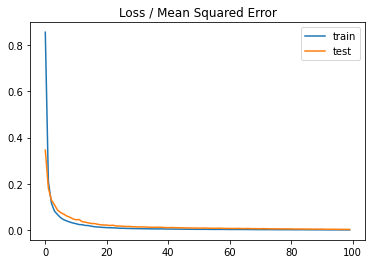

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))

# fit model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(train_x, train_y, verbose=0)
test_mse = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Mean Squared Logarithmic Error Loss
There may be problems in which the target value has a spread of values and when predicting a large value, you may not want to punish a model as heavily as mean squared error.

Instead, you can first calculate the natural logarithm of each of the predicted values, then calculate the mean squared error.
This is called the Mean Squared Logarithmic Error loss.

It has the effect of relaxing the punishing effect of large differences in large predicted values.

As a loss measure, it may be more appropriate when the model is predicting unscaled quantities directly.
Nevertheless, we can demonstrate this loss function using our simple regression problem.

The model can be updated to use the ‘mean_squared_logarithmic_error‘ loss function and keep the same configuration for the output layer.
We will also track the mean squared error as a metric when fitting the model so that we can use

Train: 0.004, Test: 0.012


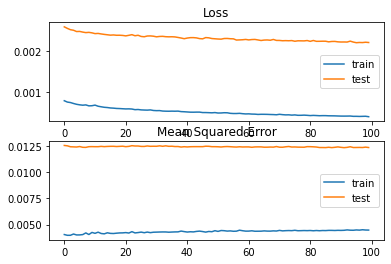

In [7]:
model.compile(loss='mean_squared_logarithmic_error', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['mse'])

# fit model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=100, verbose=0)

# evaluate the model
_, train_mse = model.evaluate(train_x, train_y, verbose=0)
_, test_mse = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot mse during training
pyplot.subplot(212)
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['mse'], label='train')
pyplot.plot(history.history['val_mse'], label='test')
pyplot.legend()
pyplot.show()

### Mean Absolute Error Loss
On some regression problems, the distribution of the target variable may be mostly Gaussian, but may have outliers, e.g. large or small values far from the mean value.

The Mean Absolute Error, or MAE, loss is an appropriate loss function in this case as it is more robust to outliers.
It is calculated as the average of the absolute difference between the actual and predicted values.

Train: 0.004, Test: 0.007


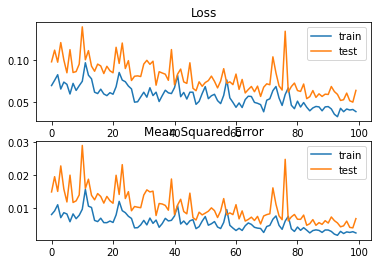

In [8]:
model.compile(loss='mean_absolute_error', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['mse'])

# fit model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=100, verbose=0)

# evaluate the model
_, train_mse = model.evaluate(train_x, train_y, verbose=0)
_, test_mse = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot mse during training
pyplot.subplot(212)
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['mse'], label='train')
pyplot.plot(history.history['val_mse'], label='test')
pyplot.legend()
pyplot.show()

### The take away message

Keep you code modular so you can simple change a value and it'll work



# Batch Normalisation

Batch normalization is a layer that allows every layer of the network to do "learning" more independently.
It is used to normalise the output of the previous layers.

* Using batch normalization learning becomes efficient also it can be used as regularisation to avoid overfitting of the model.
* The layer is added to the sequential model to standardise the input or the outputs.
* It can be used at several points in between the layers of the model.

We will use a standard binary classification problem that defines two two-dimensional concentric circles of observations, one circle for each class.

Each observation has two input variables with the same scale and a class output value of either 0 or 1.
This dataset is called the “circles” dataset because of the shape of the observations in each class when plotted.

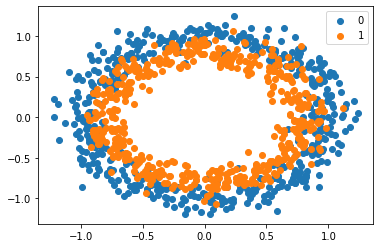

In [9]:
# scatter plot of the circles dataset with points colored by class
from sklearn.datasets import make_circles
from numpy import where
from matplotlib import pyplot

# generate circles
x, y = make_circles(n_samples=1000, noise=0.1, random_state=1)

# select indices of points with each class label
for i in range(2):
	samples_ix = where(y == i)
	pyplot.scatter(x[samples_ix, 0], x[samples_ix, 1], label=str(i))
pyplot.legend()
pyplot.show()

Let's build a simple model

Train: 0.844, Test: 0.850


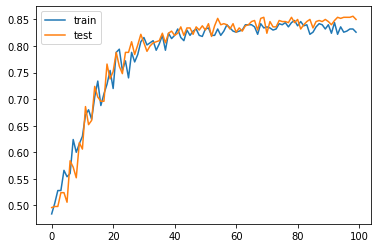

In [10]:
# split into train and test
n_train = 500
trainX, testX = x[:n_train, :], x[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Now add batch normalisation


Train: 0.830, Test: 0.842


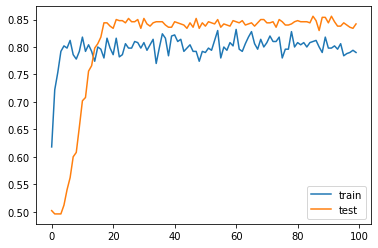

In [11]:
from tensorflow.keras.layers import BatchNormalization

# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


It learns much faster

The original paper suggested doing the Batch normalisation before the activation. Let's try it.

Train: 0.840, Test: 0.830


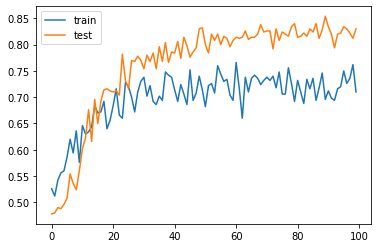

In [12]:
from tensorflow.keras.layers import Activation

# define model
model = Sequential()
model.add(Dense(50, input_dim=2, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

The learning is slower and less accurate.
So be careful.

# Dropout

Dropout is a method to combat overfitting in neural networks.
The idea behind Dropout is to approximate an exponential number of models to combine them and predict the output.

Dropout can be easily implemented by randomly disconnecting some neurons of the network, resulting in what is called a “thinned” network.

![dropout](images/dropout.png)


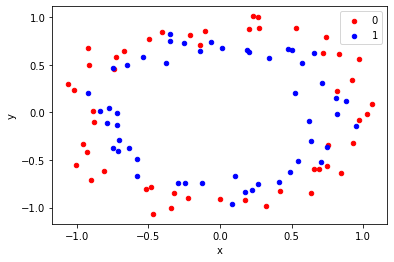

In [13]:
# generate two circles dataset
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=100, noise=0.1, random_state=1)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

An overfitting model

Train: 1.000, Test: 0.771


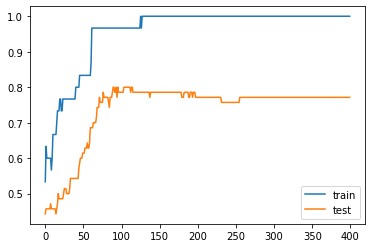

In [14]:
# split into train and test
n_train = 30
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=400, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

The plot and accuracies are classic signs of overfitting

Train: 0.967, Test: 0.786


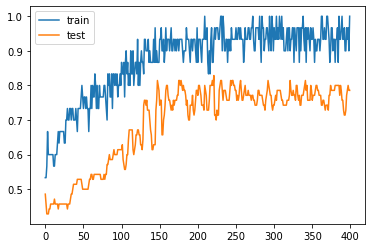

In [15]:
from tensorflow.keras.layers import Dropout

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=400, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

# Combining Drop and BN

The Batch Normalisation normalise the output of the previous layers.
If the previous or subsequent layer is a Dropout, the results from the BN can become skewed

If you need to mix them, apply them to separate blocks

# Check and arrange your input dataset properly


Even though it might seem surprising, the most important key point of a machine learning project does not regard machine learning: it regards your dataset properties and arrangement.

First of all, before starting any ML activity, you have to ask yourself: do I have enough data to solve this problem with machine learning?

For example:
* finding anomalies when you only have 3 will be really hard to do accurately
* classification into class where you have 50,000 of class A and only 50 of class B will require other tricks, such as data augmentation

Make sure it is in a format that is quick and easy to load.
If you need to run preprocessing on the data, before a run consider caching it.

![cache](images/cache.png)

This is really important with large jobs using GPUs.
You'll find data IO can become a bottleneck.

In [16]:
if False:
        parameters_root = PosixS3Name(join(f"{month:02}", parameters_stub))
        build_directories(parameters_root.posix_name)

        yaml_file = PosixS3Name(join(parameters_root.name, "run_details.yaml"))
        if not exists(yaml_file.posix_name):
            with open(yaml_file.posix_name, "w") as file_:
                YAML().dump(kwargs, file_)

        cache_file_1 = PosixS3Name(join(parameters_root.name, FILE_PREPROCESSED_DATA))

        # The following files is not needed for training once the preprocessing is done,
        # but are needed for the prediction
        cache_file_2 = PosixS3Name(join(parameters_root.name, FILE_SCALERS))

        # Copy any files on S3
        if PosixS3Name.use_s3():
            s3_helper.copy_from_s3(
                cache_file_1.s3_name,
                cache_file_1.posix_name,
            )
            s3_helper.copy_from_s3(
                cache_file_2.s3_name,
                cache_file_2.posix_name,
            )

        # The various wave data training/test data
        y_data = {}

        # Get the ignore values
        overwrite_model = kwargs["overwrite_model"]
        overwrite_all = kwargs["overwrite_all"]
        ignore_checkpoints = kwargs["ignore_checkpoints"]

        # Do we have a cache
        if (
            exists(cache_file_1.posix_name)
            and exists(cache_file_2.posix_name)
            and not overwrite_all
        ):
            LOGGER.info(f"Loading cache file: {cache_file_1.posix_name}")
            data: Union[Dict, object] = hickle.load(cache_file_1.posix_name)
            features = data["features"]
            other_features = data["other_features"]
            x_train = data["x_train"]
            x_test = data["x_test"]
            x_train_other = data["x_train_other"]
            x_test_other = data["x_test_other"]
            for spectra in SPECTRA_PARAMETERS:
                key1 = f"y_train_{spectra}"
                y_data[key1] = data[key1]
                key2 = f"y_test_{spectra}"
                y_data[key2] = data[key2]

        else:
            cache_file_3 = PosixS3Name(join(parameters_root.name, "raw_data.h5"))
            if exists(cache_file_3.posix_name) and not overwrite_all:
                LOGGER.info(f"Saving cache file: {cache_file_3.posix_name}")
                raw_data = hickle.load(cache_file_3.posix_name)

            else:
                LOGGER.info(f"Building raw data cache file: {cache_file_3.posix_name}")
                raw_data = get_raw_data_spectra(
                    kwargs["data_file"],
                    month,
                    kwargs["month_padding"],
                    kwargs["prediction_point"],
                    kwargs["outer_only"],
                )
                LOGGER.info(f"Saving cache file: {cache_file_3.posix_name}")
                hickle.dump(raw_data, cache_file_3.posix_name, mode="w")

# Data Loaders

Using a python generator is really not a good way to load data in a ML environment.
All the frameworks allow you to create DataLoaders.
These run as sub-processes and can significantly improve th speed as whilst the GPU is processing, the CPU is preloading N new batches to feed to the GPU.
This really becomes important for datasets that are too big to fit in memory.

This can involve pre-processing images, of calculating gaussians, injecting features, etc.


# Batch size

Neural networks are trained using gradient descent where the estimate of the error used to update the weights is calculated based on a subset of the training dataset.

The number of examples from the training dataset used in the estimate of the error gradient is called the batch size and is an important hyperparameter that influences the dynamics of the learning algorithm.

Big batch sizes are fast especially with GPUs, but smaller batch sizes are used for two main reasons:

* Smaller batch sizes are noisy, offering a regularizing effect and lower generalisation error.
* Smaller batch sizes make it easier to fit one batch worth of training data in memory (i.e. when using a GPU on a laptop).

# Use readable variable names

Nowadays we tend to work in teams more and more.
Use variable names that are understandable.

Back in the late 1970s (yes I am that old) variables had finite lengths, and in FORTRANs case the first letter defined the type i,j,k integers.
We've moved on in the last 40 years, but I still see code where the writer knows what the variables mean, but they still use a,b,a1 etc. It makes it very hard to read

# Logs and Losses

Keep the history of the run in the directory so you can go back and look at the logs and losses to identify problem areas.

![losses](images/losses.png)

# Store results before printing

Don't print final results directly from ML runs.
It is sometimes a good idea to print 'sanity' checks, but if you do, use multiprocessing and don't interrupt the ML process.

1. It is slow
2. If you need to change the print (for a Journal or presentation) you don't have to run the model again

For this I use a package called Hickle, which pickles numpy to hdf

In [ ]:
if False:
    raw_data = {}
    for label in ["outer", "inner"]:
        raw_data[label] = get_raw_data_spectra(
            kwargs["data_file"],
            month,
            kwargs["month_padding"],
            kwargs["prediction_point"],
            label,
        )

    LOGGER.info(f"Saving cache file: {cache_file_3.posix_name}")
    hickle.dump(raw_data, cache_file_3.posix_name, mode="w")


# Adaptive Learning Rates & Early stopping


For long runs use adaptive learning rates to refine the results around the minima

If the system doesn't improve after a certain period save time and stop


In [ ]:
if False:
    history = model.fit(
        [x_train, x_train_other],
        y_train,
        validation_data=([x_test, x_test_other], y_test),
        epochs=kwargs["epochs"],
        batch_size=kwargs["batch_size"],
        verbose=kwargs["verbose_tf"],
        callbacks=[
            AdaptiveEarlyStopping(
                monitor="val_loss",
                verbose=kwargs["verbose_tf"],
                patience_boundaries={
                    (0, 100): 70,
                    (100, 200): 40,
                    (200, 1000): 20,
                },
                restore_best_weights=True,
                min_delta=1e-5,
            ),
            ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=15,
                verbose=kwargs["verbose_tf"],
                min_lr=1e-6,
            ),
            ModelCheckpoint(
                filepath=check_point_file.posix_name,
                monitor="val_loss",
                verbose=kwargs["verbose_tf"],
                save_best_only=True,
            )
            if run_from_check_point
            else EveryNthBetterModelCheckpoint(
                start_saving_each_better=40,
                every_nth=8,
                filename=check_point_file.posix_name,
                monitor="val_loss",
                verbose=kwargs["verbose_tf"],
                save_best_only=True,
            ),
            S3ModelCheckpoint(
                s3_bucket=kwargs["s3_bucket"]
                if PosixS3Name.use_s3()
                else None,
                filename=check_point_file,
                pause=900,
            ),
        ],
    )
